### The German Traffic Sign Benchmark

Student Name 1: Matteo Anelli

Student Name 2: José Manuel Pérez

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
!wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2019-04-01 08:48:46--  http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
Resolving benchmark.ini.rub.de (benchmark.ini.rub.de)... 134.147.122.15
Connecting to benchmark.ini.rub.de (benchmark.ini.rub.de)|134.147.122.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip   100%[===================>]   1.55G  18.5MB/s    in 79s     

2019-04-01 08:50:05 (20.1 MB/s) - ‘FullIJCNN2013.zip’ saved [1661866983/1661866983]

Archive:  FullIJCNN2013.zip
   creating: FullIJCNN2013/
   creating: FullIJCNN2013/00/
  inflating: FullIJCNN2013/00000.ppm  
  inflating: FullIJCNN2013/00001.ppm  
  inflating: FullIJCNN2013/00002.ppm  
  inflating: FullIJCNN2013/00003.ppm  
  inflating: FullIJCNN2013/00004.ppm  
  inflating: FullIJCNN2013/00005.ppm  
  inflating: FullIJCNN2013/00006.ppm  
  inflating: FullIJCNN2013/00007.ppm  
  inflating: FullIJCNN2013/00008.ppm  
  inflating: FullIJCNN201

In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

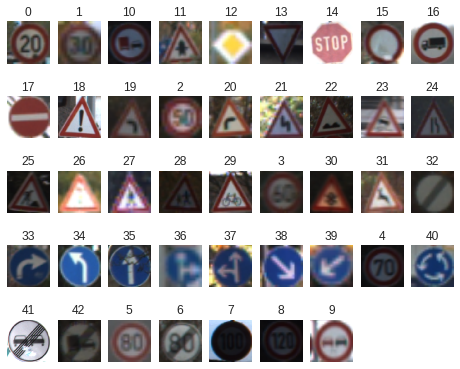

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.2: Convolutional Neural Network

In [66]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam


cnn = Sequential()

cnn.add(Conv2D(filters=32, strides=(2, 2), kernel_size=(4, 4), padding='same', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(filters=64, strides=(1, 1), kernel_size=(4, 4), padding='same', activation = 'relu'))
cnn.add(Conv2D(filters=128, strides=(1, 1), kernel_size=(4, 4), padding='same', activation = 'relu'))
cnn.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
cnn.add(Conv2D(filters=32, strides=(1, 1), kernel_size=(3, 3), padding='same', activation = 'relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())

cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dropout(0.4))
cnn.add(Dense(64, activation = 'relu'))
cnn.add(Dropout(0.3))

cnn.add(Dense(num_classes))
cnn.add(Activation('softmax'))



#cnn = Sequential()
#cnn.add(Conv2D(filters=8, strides=(2, 2), kernel_size=(3, 3), padding='same', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
#cnn.add(Activation('relu'))
#cnn.add(Conv2D(filters=32, strides=(2, 2), kernel_size=(3, 3), padding='same'))
#cnn.add(Activation('relu'))
#cnn.add(MaxPooling2D(pool_size=(2, 2)))
#cnn.add(Conv2D(filters=64, strides=(1, 1), kernel_size=(3, 3), padding='same'))
#cnn.add(Activation('relu'))
#cnn.add(MaxPooling2D(pool_size=(2, 2)))
#cnn.add(Conv2D(filters=128, strides=(1, 1), kernel_size=(3, 3), padding='same'))
#cnn.add(Activation('relu'))
#cnn.add(MaxPooling2D(pool_size=(2, 2))
#cnn.add(Flatten())
#cnn.add(Activation('relu'))
#cnn.add(Dense(512, activation='relu'))
#cnn.add(Dense(256, activation='relu'))
#cnn.add(Dropout(0.1))
#cnn.add(Dense(256, activation='relu'))
#cnn.add(Dropout(0.3))
#cnn.add(Dense(128, activation='relu'))
#cnn.add(Dropout(0.1))
#cnn.add(Dense(num_classes))
#cnn.add(Activation('softmax'))

opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=False)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 112, 112, 32)      1568      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 56, 56, 64)        32832     
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 56, 56, 128)       131200    
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 28, 28, 32)        36896     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 14, 14, 32)        0         
__________

In [67]:
data = cnn.fit(tr_signs, tr_labels, batch_size=16, epochs=150, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 600 samples, validate on 252 samples
Epoch 1/150
 - 3s - loss: 3.7384 - acc: 0.0317 - val_loss: 3.7036 - val_acc: 0.0556
Epoch 2/150
 - 2s - loss: 3.6777 - acc: 0.0533 - val_loss: 3.6325 - val_acc: 0.1032
Epoch 3/150
 - 2s - loss: 3.6465 - acc: 0.0883 - val_loss: 3.5507 - val_acc: 0.2024
Epoch 4/150
 - 2s - loss: 3.4829 - acc: 0.1367 - val_loss: 3.4272 - val_acc: 0.2857
Epoch 5/150
 - 2s - loss: 3.3216 - acc: 0.1883 - val_loss: 3.1560 - val_acc: 0.2460
Epoch 6/150
 - 2s - loss: 3.1292 - acc: 0.2150 - val_loss: 3.0334 - val_acc: 0.2619
Epoch 7/150
 - 2s - loss: 2.9794 - acc: 0.2483 - val_loss: 2.8996 - val_acc: 0.3571
Epoch 8/150
 - 2s - loss: 2.9183 - acc: 0.2767 - val_loss: 2.7481 - val_acc: 0.3929
Epoch 9/150
 - 2s - loss: 2.7929 - acc: 0.3050 - val_loss: 2.5856 - val_acc: 0.4444
Epoch 10/150
 - 2s - loss: 2.6630 - acc: 0.3067 - val_loss: 2.5323 - val_acc: 0.3929
Epoch 11/150
 - 2s - loss: 2.6144 - acc: 0.3367 - val_loss: 2.4401 - val_acc: 0.4127
Epoch 12/150
 - 2s - loss: 2

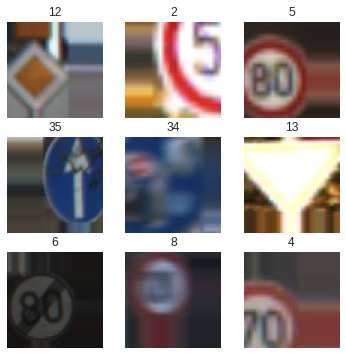

Epoch 1/100
 - 8s - loss: 3.6496 - acc: 0.0625 - val_loss: 3.5812 - val_acc: 0.0595
Epoch 2/100
 - 7s - loss: 3.6458 - acc: 0.0507 - val_loss: 3.6076 - val_acc: 0.1587
Epoch 3/100
 - 7s - loss: 3.6078 - acc: 0.0810 - val_loss: 3.5405 - val_acc: 0.1746
Epoch 4/100
 - 7s - loss: 3.5891 - acc: 0.0760 - val_loss: 3.5059 - val_acc: 0.1151
Epoch 5/100
 - 7s - loss: 3.5608 - acc: 0.0828 - val_loss: 3.4938 - val_acc: 0.1548
Epoch 6/100
 - 7s - loss: 3.4999 - acc: 0.1014 - val_loss: 3.4849 - val_acc: 0.1190
Epoch 7/100
 - 7s - loss: 3.5095 - acc: 0.0980 - val_loss: 3.4563 - val_acc: 0.1627
Epoch 8/100
 - 7s - loss: 3.4579 - acc: 0.0929 - val_loss: 3.4187 - val_acc: 0.1548
Epoch 9/100
 - 7s - loss: 3.4392 - acc: 0.1132 - val_loss: 3.4256 - val_acc: 0.1508
Epoch 10/100
 - 7s - loss: 3.4591 - acc: 0.1317 - val_loss: 3.3868 - val_acc: 0.1587
Epoch 11/100
 - 7s - loss: 3.3773 - acc: 0.1284 - val_loss: 3.3611 - val_acc: 0.1429
Epoch 12/100
 - 7s - loss: 3.3758 - acc: 0.1335 - val_loss: 3.3439 - val_a

In [62]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
datagen.fit(tr_signs, augment=True)

for x_batch, y_batch in datagen.flow(tr_signs, tr_labels, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    break

train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)
data = cnn.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=16), epochs=100, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))